# Habitat volume in trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from itertools import product

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import metabolic as mi
import thermodyn
import util

In [32]:
ds = xr.merge((
    util.retrieve_woa_dataset('oxygen', 0).isel(time=0, drop=True)[['o_an', 'depth_bnds']],
    util.retrieve_woa_dataset(['temperature', 'salinity'], 0).isel(time=0, drop=True)[['t_an', 's_an']],
)).sel(depth=slice(0, 1000.))

depth = xr.full_like(ds.t_an, fill_value=1.) * ds.depth
ds['pO2'] = thermodyn.compute_pO2(ds.o_an, ds.t_an, ds.s_an, depth)

ds['dz'] = ds.depth_bnds.diff('nbounds').squeeze()
ds['area'] = util.compute_grid_area(ds)
ds['volume'] = ds.dz * ds.area
ds.volume.attrs['long_name'] = 'Volume'
ds.volume.attrs['units'] = 'm^3'

ds = ds.compute()
ds

<xarray.Dataset>
Dimensions:     (depth: 47, lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * depth       (depth) float32 0.0 5.0 10.0 15.0 ... 850.0 900.0 950.0 1e+03
Dimensions without coordinates: nbounds
Data variables:
    o_an        (depth, lat, lon) float32 nan nan nan nan ... 303.3 303.3 303.3
    depth_bnds  (depth, nbounds) float32 0.0 2.5 2.5 ... 975.0 975.0 1.025e+03
    t_an        (depth, lat, lon) float32 nan nan nan ... -0.1925 -0.1925
    s_an        (depth, lat, lon) float32 nan nan nan nan ... 34.91 34.91 34.91
    pO2         (depth, lat, lon) float32 nan nan nan nan ... 20.49 20.49 20.49
    dz          (depth) float32 2.5 5.0 5.0 5.0 5.0 ... 50.0 50.0 50.0 50.0 50.0
    area        (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    volume      (depth, lat, lon) float64 2.697e+08 2.697e+08 ... 5.395e+09
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : mole_concentrat...
    summary:                         Climatological mean dissolved oxygen for...
    references:                      Garcia, H. E., K. Weathers, C. R. Paver,...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29

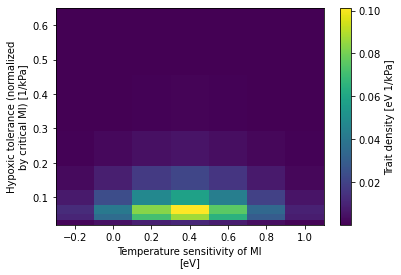

In [33]:
curator = util.curator_local_assets()
cat = curator.open_catalog()  
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_wgt

trait_spc_wgt.plot();

In [36]:
trait_spc_wgt

<xarray.DataArray 'trait_spc_wgt' (Ac: 8, Eo: 7)>
array([[1.34680503e-03, 4.47545908e-03, 9.02342586e-03, 1.10384049e-02,
        8.19298555e-03, 3.68959807e-03, 1.00813091e-03],
       [1.06140909e-02, 3.52708287e-02, 7.11130864e-02, 8.69930173e-02,
        6.45684353e-02, 2.90775046e-02, 7.94502019e-03],
       [1.23591079e-02, 4.10695540e-02, 8.28044832e-02, 1.01295165e-01,
        7.51838542e-02, 3.38580121e-02, 9.25122680e-03],
       [7.08526930e-03, 2.35444865e-02, 4.74704214e-02, 5.80708193e-02,
        4.31016426e-02, 1.94102305e-02, 5.30357316e-03],
       [2.56701395e-03, 8.53023685e-03, 1.71986736e-02, 2.10392290e-02,
        1.56158521e-02, 7.03238370e-03, 1.92150019e-03],
       [6.36403263e-04, 2.11478032e-03, 4.26382256e-03, 5.21595685e-03,
        3.87141615e-03, 1.74343888e-03, 4.76370216e-04],
       [1.11418788e-04, 3.70246781e-04, 7.46491996e-04, 9.13187634e-04,
        6.77791144e-04, 3.05233896e-04, 8.34008799e-05],
       [1.39113912e-05, 4.62278214e-05, 9.32045879e-05, 1.14017669e-04,
        8.46268206e-05, 3.81105218e-05, 1.04131654e-05]])
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Attributes:
    N_traits:   56
    long_name:  Trait density
    units:      eV 1/kPa

In [45]:
ni, nj = trait_spc_wgt.shape

vol = xr.full_like(trait_spc_wgt, fill_value=0.)

for i, Ac in enumerate(trait_spc_wgt.Ac.values):
    for j, Eo in enumerate(trait_spc_wgt.Eo.values):
    
        Phi_prime = mi.Phi(ds.pO2, ds.t_an, Ac, Eo, dEodT=mi.dEodT_bar)

        viable_trait_mask = xr.where(Phi_prime > 1, 1.0, 0.0) 

        vol[i, j] += (ds.volume * viable_trait_mask).sum(['depth', 'lat', 'lon'])


vol_percent = 100.0 * vol / ds.volume.sum()
vol_percent.attrs['long_name'] = 'Ocean volume'
vol_percent.attrs['units'] = '%'

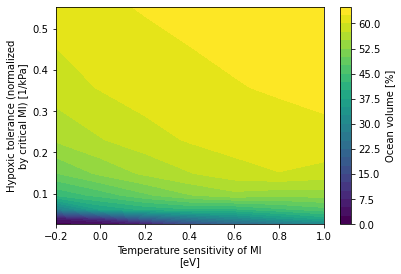

In [46]:
vol_percent.plot.contourf(levels=30)

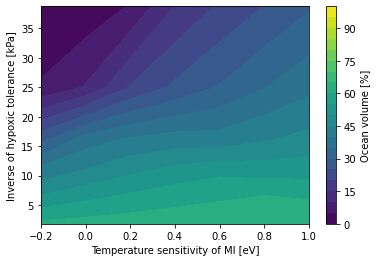

In [60]:
plt.contourf(vol_percent.Eo, 1/vol_percent.Ac, vol_percent, levels=np.arange(0, 105, 5))
cb = plt.colorbar()
plt.xlabel(util.attrs_label(vol_percent.Eo.attrs));

inv_attrs = dict(**vol_percent.Ac.attrs)
inv_attrs['long_name'] = 'Inverse of hypoxic tolerance'
inv_attrs['units'] = 'kPa'
plt.ylabel(util.attrs_label(inv_attrs));
cb.ax.set_ylabel(util.attrs_label(vol_percent.attrs));